In [1]:
import os
import wave
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, filtfilt, lfilter
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')


In [3]:
def load_audio_from_folder(folder_path):
    audio_data = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            full_path = os.path.join(folder_path, filename)
            try:
                signal, sr = librosa.load(full_path, sr=None)  # sr=None untuk mempertahankan frekuensi asli
                duration = len(signal) / sr
                audio_data.append({
                    'filename': full_path,
                    'signal': signal,
                    'sampling_rate': sr,
                    'duration': duration
                })
            except Exception as e:
                print(f"Error reading {full_path}: {e}")

    return audio_data

folder_path = 'set_b'
audio_data = load_audio_from_folder(folder_path)
df = pd.DataFrame(audio_data)
df.head()

,filename,signal,sampling_rate,duration
0,set_b/normal__235_1308749032454_C.wav,"[0.088378906, 0.08609009, 0.09036255, 0.089599...",4000,1.20625
1,set_b/normal__152_1306779561195_B1.wav,"[-0.007873535, -0.0074157715, -0.0057373047, -...",4000,4.17125
2,set_b/normal__188_1308074301731_C.wav,"[-0.035736084, -0.036743164, -0.031066895, -0....",4000,7.71700
3,set_b/normal_noisynormal_296_1311682952647_D.wav,"[0.030151367, 0.028686523, 0.031280518, 0.0215...",4000,10.18350
4,set_b/normal__141_1306520154450_C.wav,"[-0.0051879883, -0.00036621094, 0.006591797, 0...",4000,3.24275


## Preprocessing

In [4]:
import numpy as np
from scipy.signal import butter, lfilter

def normalize_audio(signal):
    return signal / np.max(np.abs(signal))

def band_pass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

def clip_or_pad(signal, target_samples):
    if len(signal) < target_samples:
        signal = np.pad(signal, (0, target_samples - len(signal)), 'constant')
    else:
        signal = signal[:target_samples]
    return signal

def preprocess(row, target_duration):
    signal = row['signal']
    sr = row['sampling_rate']
    target_samples = int(target_duration * sr)

    normalized_signal = normalize_audio(signal)

    processed_signal = clip_or_pad(normalized_signal, target_samples)

    filtered_signal = band_pass_filter(processed_signal, lowcut=100, highcut=1000, fs=sr)

    return filtered_signal

target_duration = 6
df['processed_signal'] = df.apply(lambda row: preprocess(row, target_duration), axis=1)


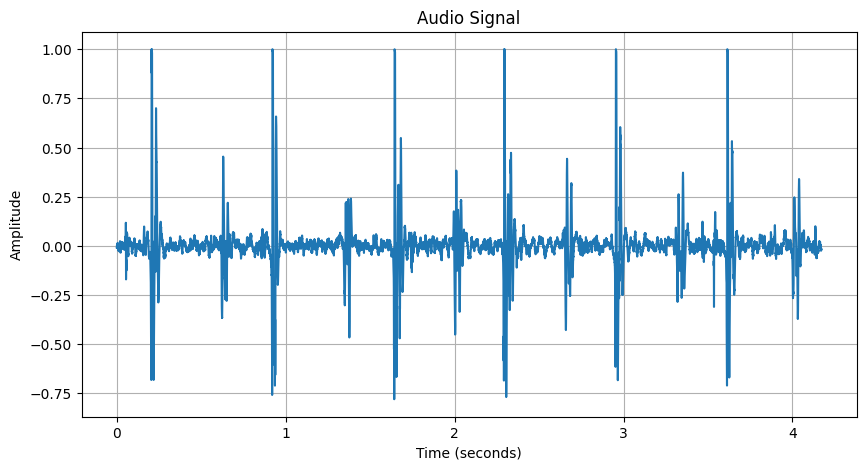

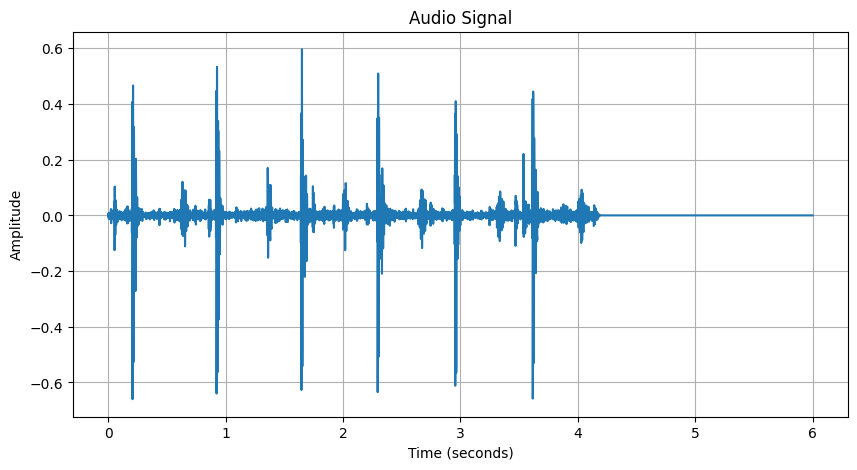

In [5]:
def plot_signal(signal, fs):
    """Plot the audio signal."""
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(10, 5))
    plt.plot(time, signal)
    plt.title('Audio Signal')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

fs = 4000  # Sampling rate
plot_signal(df['signal'][1], fs)
plot_signal(df['processed_signal'][1], fs)


## Feature Extraction

In [6]:
def extract_features(signal, sr):
    # Menghitung rata-rata interval detak
    intervals = np.diff(np.where(signal > 0)[0]) / sr
    mean_interval = np.mean(intervals) if len(intervals) > 0 else np.nan

    # Menghitung HRV (SDNN dan RMSSD)
    sdnn = np.std(intervals) if len(intervals) > 0 else np.nan
    rmssd = np.sqrt(np.mean(np.square(np.diff(intervals)))) if len(intervals) > 1 else np.nan

    # Menghitung FFT dan puncak frekuensi
    freqs = np.fft.rfftfreq(len(signal), d=1/sr)
    fft_values = np.abs(np.fft.rfft(signal))
    peak_freq = freqs[np.argmax(fft_values)] if len(fft_values) > 0 else np.nan

    # Menghitung energi
    energy = np.sum(signal**2)

    # Menghitung MFCC
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)

    # Zero-crossing rate
    zero_crossings = librosa.feature.zero_crossing_rate(signal)[0]
    zero_crossing_rate = np.mean(zero_crossings)

    # Spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)[0]
    spectral_centroid_mean = np.mean(spectral_centroid)

    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)[0]
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # RMS Energy
    rms = librosa.feature.rms(y=signal)[0]
    rms_mean = np.mean(rms)

    return {
        'mean_interval': mean_interval,
        'sdnn': sdnn,
        'rmssd': rmssd,
        'peak_freq': peak_freq,
        'energy': energy,
        'mfcc_mean': mfcc_mean,
        'zero_crossing_rate': zero_crossing_rate,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'chroma_mean': chroma_mean,
        'rms_mean': rms_mean
    }


def process_feature_extract(df):
    all_features = []

    for index, row in df.iterrows():
        signal = row['processed_signal']
        sr = row['sampling_rate']

        features = extract_features(signal, sr)
        features['filename'] = row['filename']

        all_features.append(features)

    return pd.DataFrame(all_features)

features_df = process_feature_extract(df)

features_df.head()

,mean_interval,sdnn,rmssd,peak_freq,energy,mfcc_mean,zero_crossing_rate,spectral_centroid_mean,spectral_bandwidth_mean,chroma_mean,rms_mean,filename
0,0.000503,0.001114,0.001613,96.000000,71.487422,"[-526.7157165080916, 56.72122601169934, -14.51...",0.018555,138.725336,86.720221,"[0.22922529113217988, 0.1735848998963379, 0.14...",0.026053,set_b/normal__235_1308749032454_C.wav
1,0.000502,0.000931,0.001352,109.166667,56.878805,"[-390.0180730672692, 162.86369163922262, -43.1...",0.087143,237.389616,185.177407,"[0.5024600319566251, 0.46984146812856425, 0.45...",0.038604,set_b/normal__152_1306779561195_B1.wav
2,0.000500,0.000701,0.001033,110.500000,62.423143,"[-270.1044817182367, 223.74806706044896, -76.7...",0.168987,310.957908,245.000191,"[0.895747907532516, 0.8211321827366496, 0.7355...",0.049470,set_b/normal__188_1308074301731_C.wav
3,0.000504,0.000821,0.001202,106.500000,136.344356,"[-242.09516589766633, 242.45822370316978, -60....",0.134921,291.162318,207.947559,"[0.5753587027115286, 0.5695606618976495, 0.503...",0.073042,set_b/normal_noisynormal_296_1311682952647_D.wav
4,0.000505,0.000984,0.001431,103.333333,58.354739,"[-438.2285564543381, 141.40413256256383, -40.9...",0.064806,218.736161,154.695273,"[0.40606082468914073, 0.3625017760439823, 0.34...",0.036490,set_b/normal__141_1306520154450_C.wav


## GMM Clustering

In [7]:
mfcc_flattened = np.array(features_df['mfcc_mean'].tolist())
chroma_flattened = np.array(features_df['chroma_mean'].tolist())

X = np.hstack((
    features_df[['mean_interval', 'sdnn', 'rmssd', 'peak_freq', 'energy','zero_crossing_rate', 'spectral_centroid_mean',
       'spectral_bandwidth_mean','rms_mean']].values,
    mfcc_flattened,chroma_flattened
))

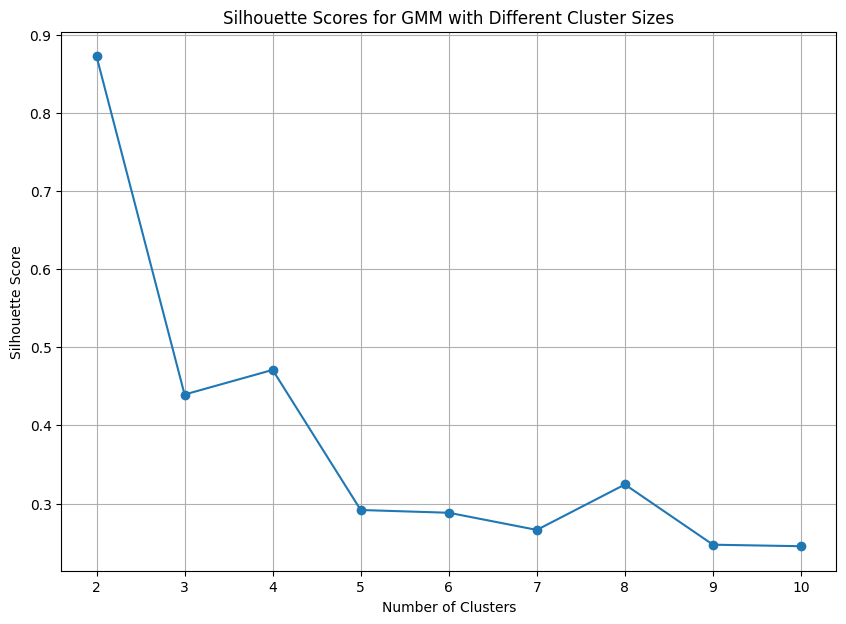

In [8]:
from sklearn.metrics import silhouette_score
def calculate_silhouette_score_gmm(max_clusters=10, X=None):
    silhouette_scores = []

    for i in range(2, max_clusters + 1):
        gmm = GaussianMixture(n_components=i, random_state=42)
        gmm.fit(X)
        labels = gmm.predict(X)
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)

    # Plot Silhouette Score
    plt.figure(figsize=(10, 7))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for GMM with Different Cluster Sizes')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

calculate_silhouette_score_gmm(max_clusters=10, X=X)

In [9]:
params = {'n_components': 4, 'covariance_type': 'tied', 'tol': 8.340127920617709e-06, 'reg_covar': 0.022917895393870926}
gmm = GaussianMixture(**params,random_state=42)
cluster = gmm.fit_predict(X)

silhouette_avg = silhouette_score(X,cluster)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.49844357393307437


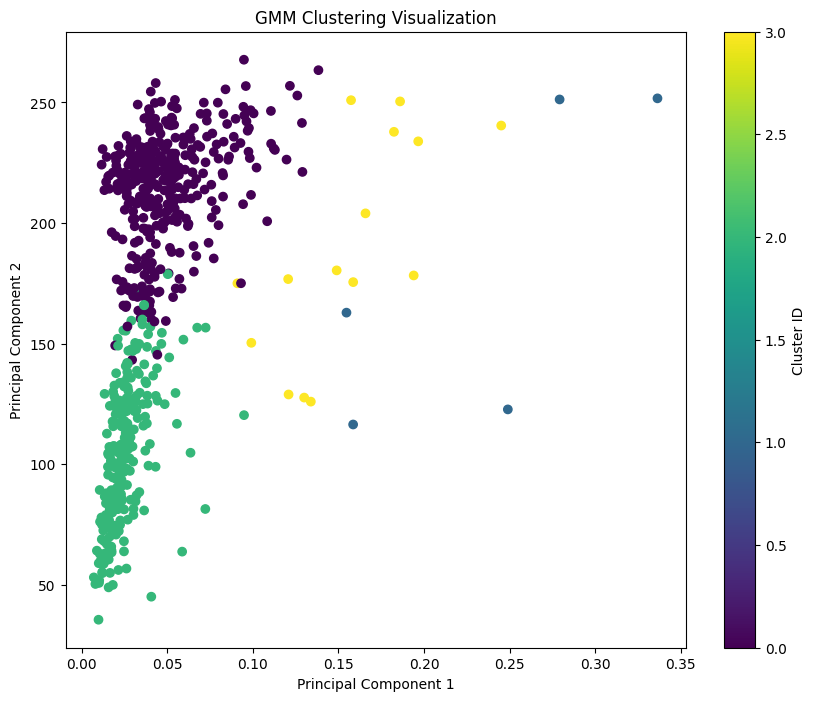

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster)
plt.xlabel('PC1')
plt.ylabel('PC2')